In [1]:
import pandas as pd
data = pd.read_csv('russo_ukraine.csv', compression='gzip', dtype=str)

In [2]:
# List all hashtags

import ast
all_hashtags_raw = data.query('entities_hashtags.notna() and entities_hashtags != "[]"').entities_hashtags.to_list()
all_hashtags_raw = list(map(lambda raw_str: ast.literal_eval(raw_str), all_hashtags_raw))
all_hashtags_count = {}
for hashtags_raw in all_hashtags_raw:
	hashtags = map(lambda d: d['text'].lower(), hashtags_raw)
	for hashtag in hashtags:
		if hashtag not in all_hashtags_count: all_hashtags_count[hashtag] = 0
		all_hashtags_count[hashtag] += 1
all_hashtags = list(all_hashtags_count.keys())
print('Num of distinct hashtags:', len(all_hashtags))

Num of distinct hashtags: 3042


In [3]:
# Remove non-English hashtags

import re
for hashtag in all_hashtags.copy():
	if re.search('[^0-9A-Za-z_]', hashtag) is not None:
		all_hashtags.remove(hashtag)
		all_hashtags_count.pop(hashtag)

print('Num of distinct English hashtags:', len(all_hashtags))

Num of distinct English hashtags: 2597


In [4]:
# Filter top 5% frequent hashtags for analysis

all_hashtags_count_sorted = sorted(list(all_hashtags_count.items()), key=lambda pair: -pair[1])
num_top = int(len(all_hashtags) * 0.05)
target_hashtags_count = all_hashtags_count_sorted[:num_top]
target_hashtags_dict = dict(target_hashtags_count)
target_hashtags = list(map(lambda tup: tup[0], target_hashtags_count))

print(num_top)
print(target_hashtags_count)

129
[('ukraine', 1954), ('russia', 726), ('putin', 349), ('kyiv', 323), ('standwithukraine', 292), ('russian', 287), ('ukrainerussiawar', 249), ('usa', 207), ('mariupol', 206), ('ukrainian', 202), ('stopwar', 183), ('zelensky', 179), ('stopthewar', 178), ('freeukraine', 176), ('stpatricksday', 169), ('weareallukrainians', 169), ('support', 168), ('gb', 166), ('nato', 157), ('breaking', 141), ('selenskyj', 132), ('ukraineunderattack', 113), ('flagnetwork', 105), ('bundestag', 102), ('bitcoin', 90), ('stoprussia', 88), ('ireland', 86), ('zakharova', 83), ('ukrainewar', 79), ('cryptocurrency', 79), ('putinwarcriminal', 74), ('russiaukrainewar', 67), ('crypto', 66), ('biden', 65), ('nft', 64), ('moldova', 64), ('russie', 63), ('rusia', 61), ('ido', 60), ('stopputin', 57), ('kiev', 50), ('putinswar', 49), ('firefighters', 49), ('ucrania', 44), ('us', 43), ('update', 41), ('uae', 40), ('ukraina', 39), ('china', 38), ('ucraina', 37), ('stopputinnow', 37), ('sbu', 37), ('mykolaiv', 37), ('war'

In [5]:
# Find co-occurrence numbers as edge weights
hashtag_pairs = {}

for hashtags_raw in all_hashtags_raw:
	if len(hashtags_raw) == 1: continue
	
	for xi in range(len(hashtags_raw) - 1):
		x = hashtags_raw[xi]['text'].lower()
		if x not in target_hashtags: continue
		for yi in range(xi + 1, len(hashtags_raw)):
			y = hashtags_raw[yi]['text'].lower()
			if y not in target_hashtags or x == y: continue

			tx, ty = (x, y) if x < y else (y, x)
			if (tx, ty) not in hashtag_pairs: hashtag_pairs[(tx, ty)] = 0
			hashtag_pairs[(tx, ty)] += 1

print('Num of edges:', len(hashtag_pairs))
print('Sum of all edge weights:', sum(hashtag_pairs.values()))

Num of edges: 838
Sum of all edge weights: 10904


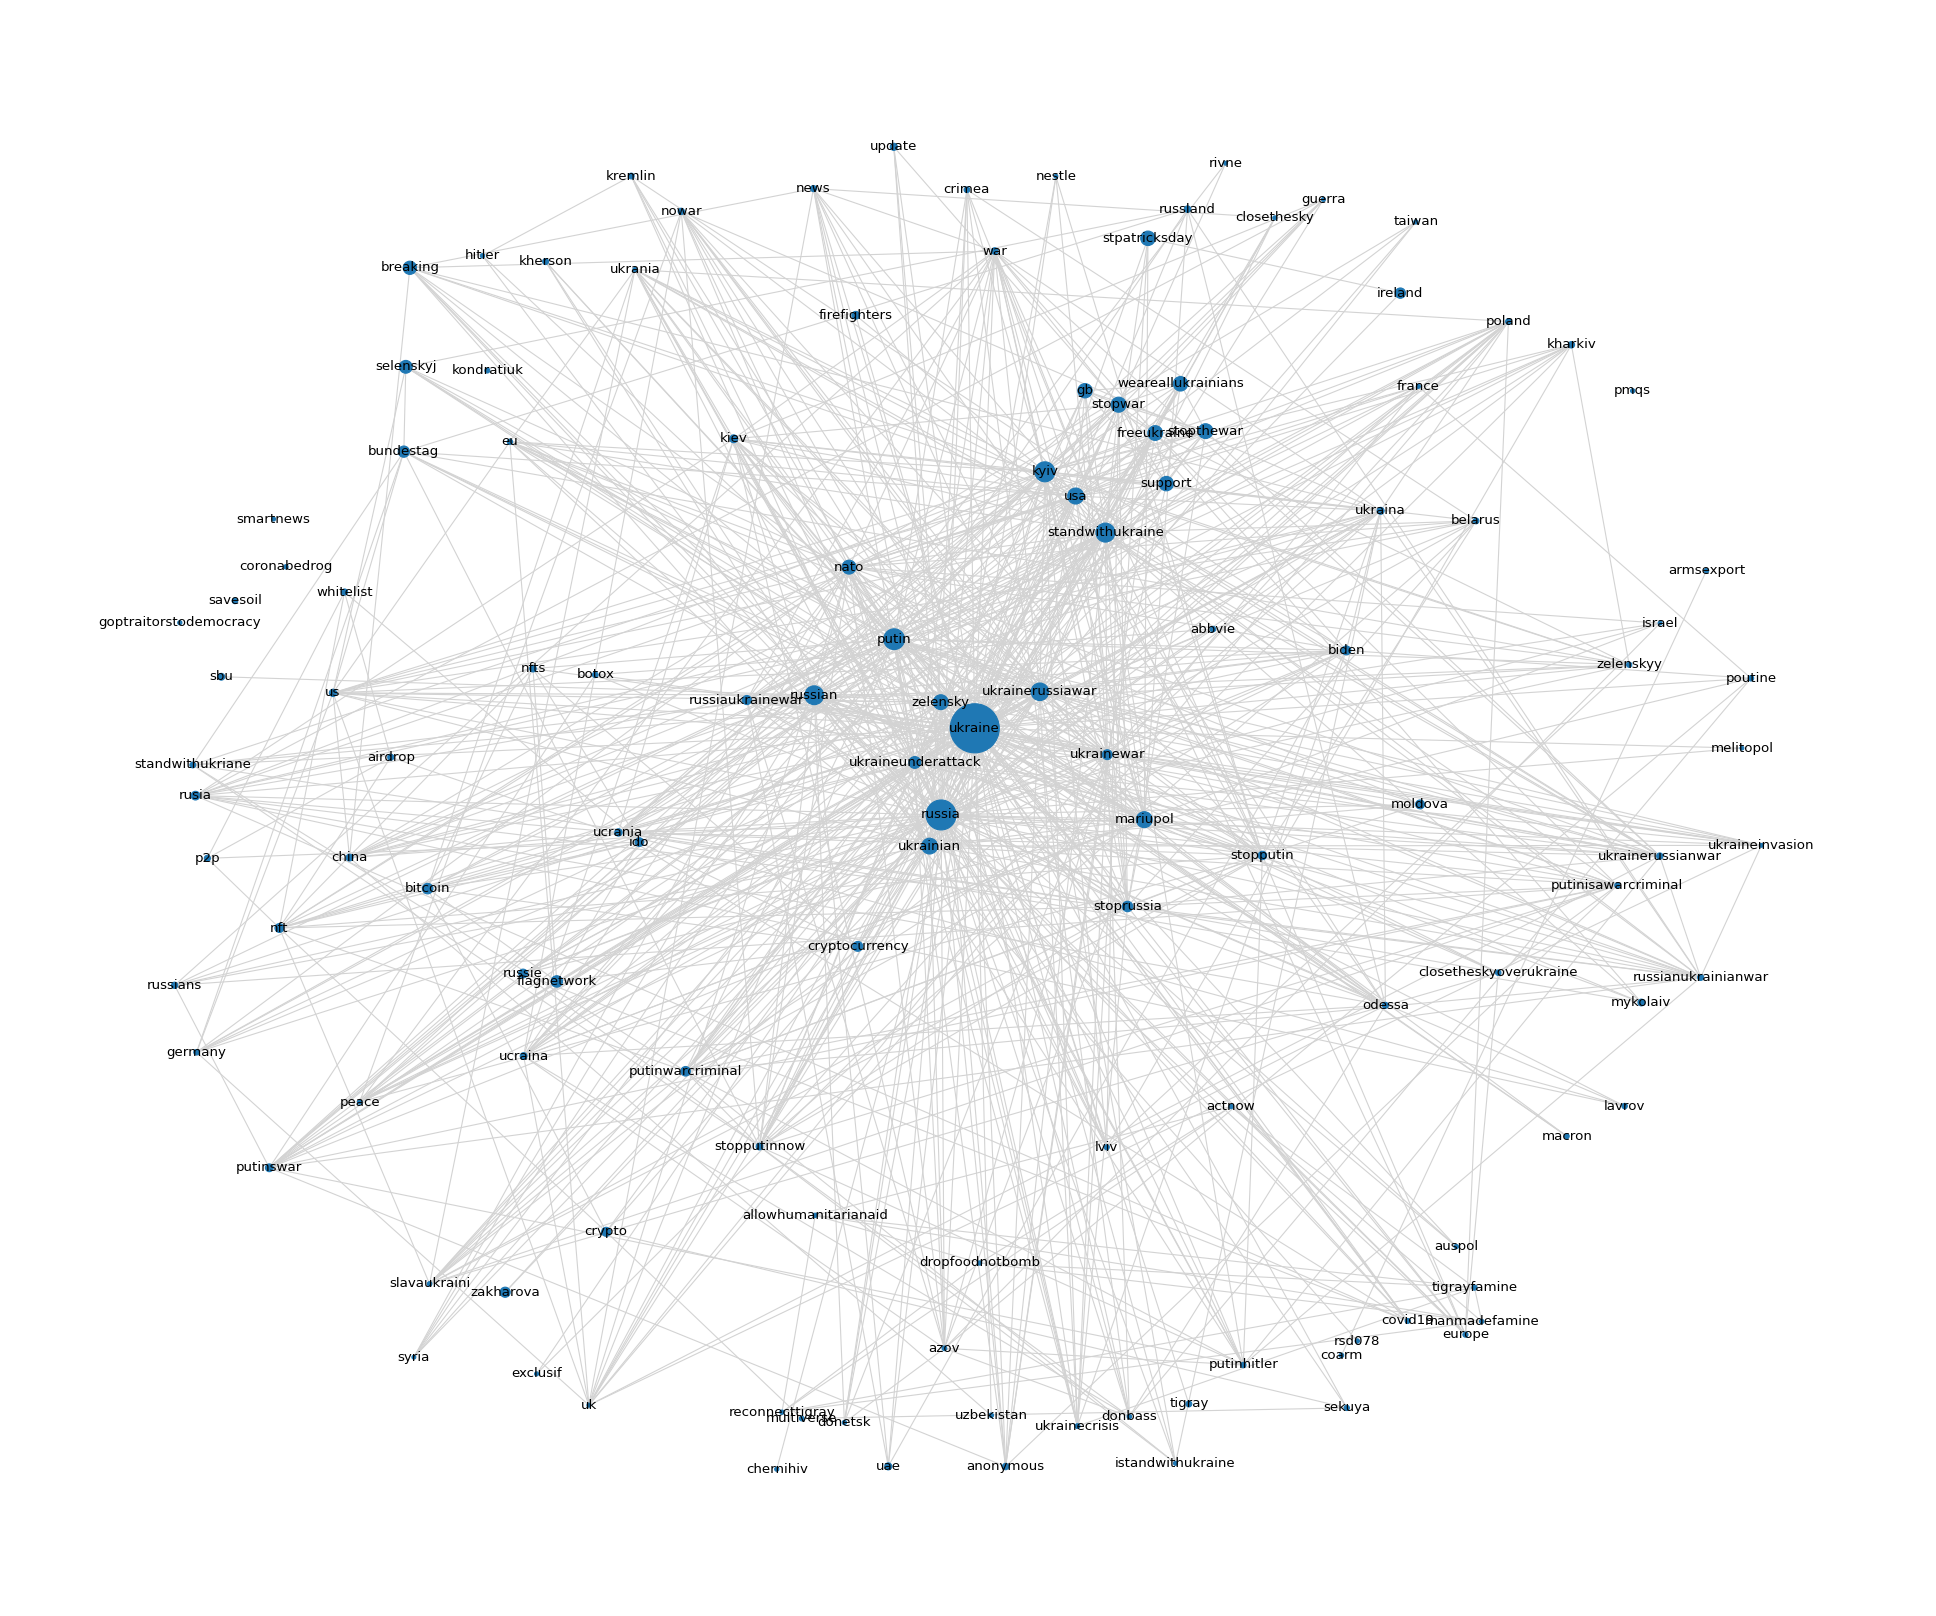

In [7]:
# Draw networkx graph
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for hashtag, count in target_hashtags_count:
	g.add_node(hashtag, weight=count)
for hashtag_pair, weight in hashtag_pairs.items():
	g.add_edge(*hashtag_pair, weight=weight)

pos = nx.spring_layout(g, k=2.2)
plt.figure(figsize=(24, 20), dpi=80)
nx.draw(
	g,
	pos=pos,
	with_labels=True,
	node_size=list(nx.get_node_attributes(g,'weight').values()),
	edge_color='lightgrey',
)